# Self-Driving Car Engineer Nanodegree
## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Import Packages

In [5]:
from pathlib import Path
import sys
import os

!mkdir car
data_folder = Path("/content/car")
os.chdir(data_folder)
!ls

CarND-Advanced-Lane-Lines


In [6]:
#!git clone https://github.com/udacity/CarND-LaneLines-P1
!git clone https://github.com/udacity/CarND-Advanced-Lane-Lines
!ls

fatal: destination path 'CarND-Advanced-Lane-Lines' already exists and is not an empty directory.
CarND-Advanced-Lane-Lines


In [7]:
data_folder = Path("/content/car/CarND-Advanced-Lane-Lines/") 
os.chdir(data_folder)
!ls

camera_cal	     harder_challenge_video.mp4  README.md
car		     LICENSE			 set_git.sh
challenge_video.mp4  m_trans.p			 test_images
examples	     output_images		 undist.p
example_writeup.pdf  project_video.mp4		 writeup_template.md


In [0]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## First, I'll compute the camera calibration using chessboard images

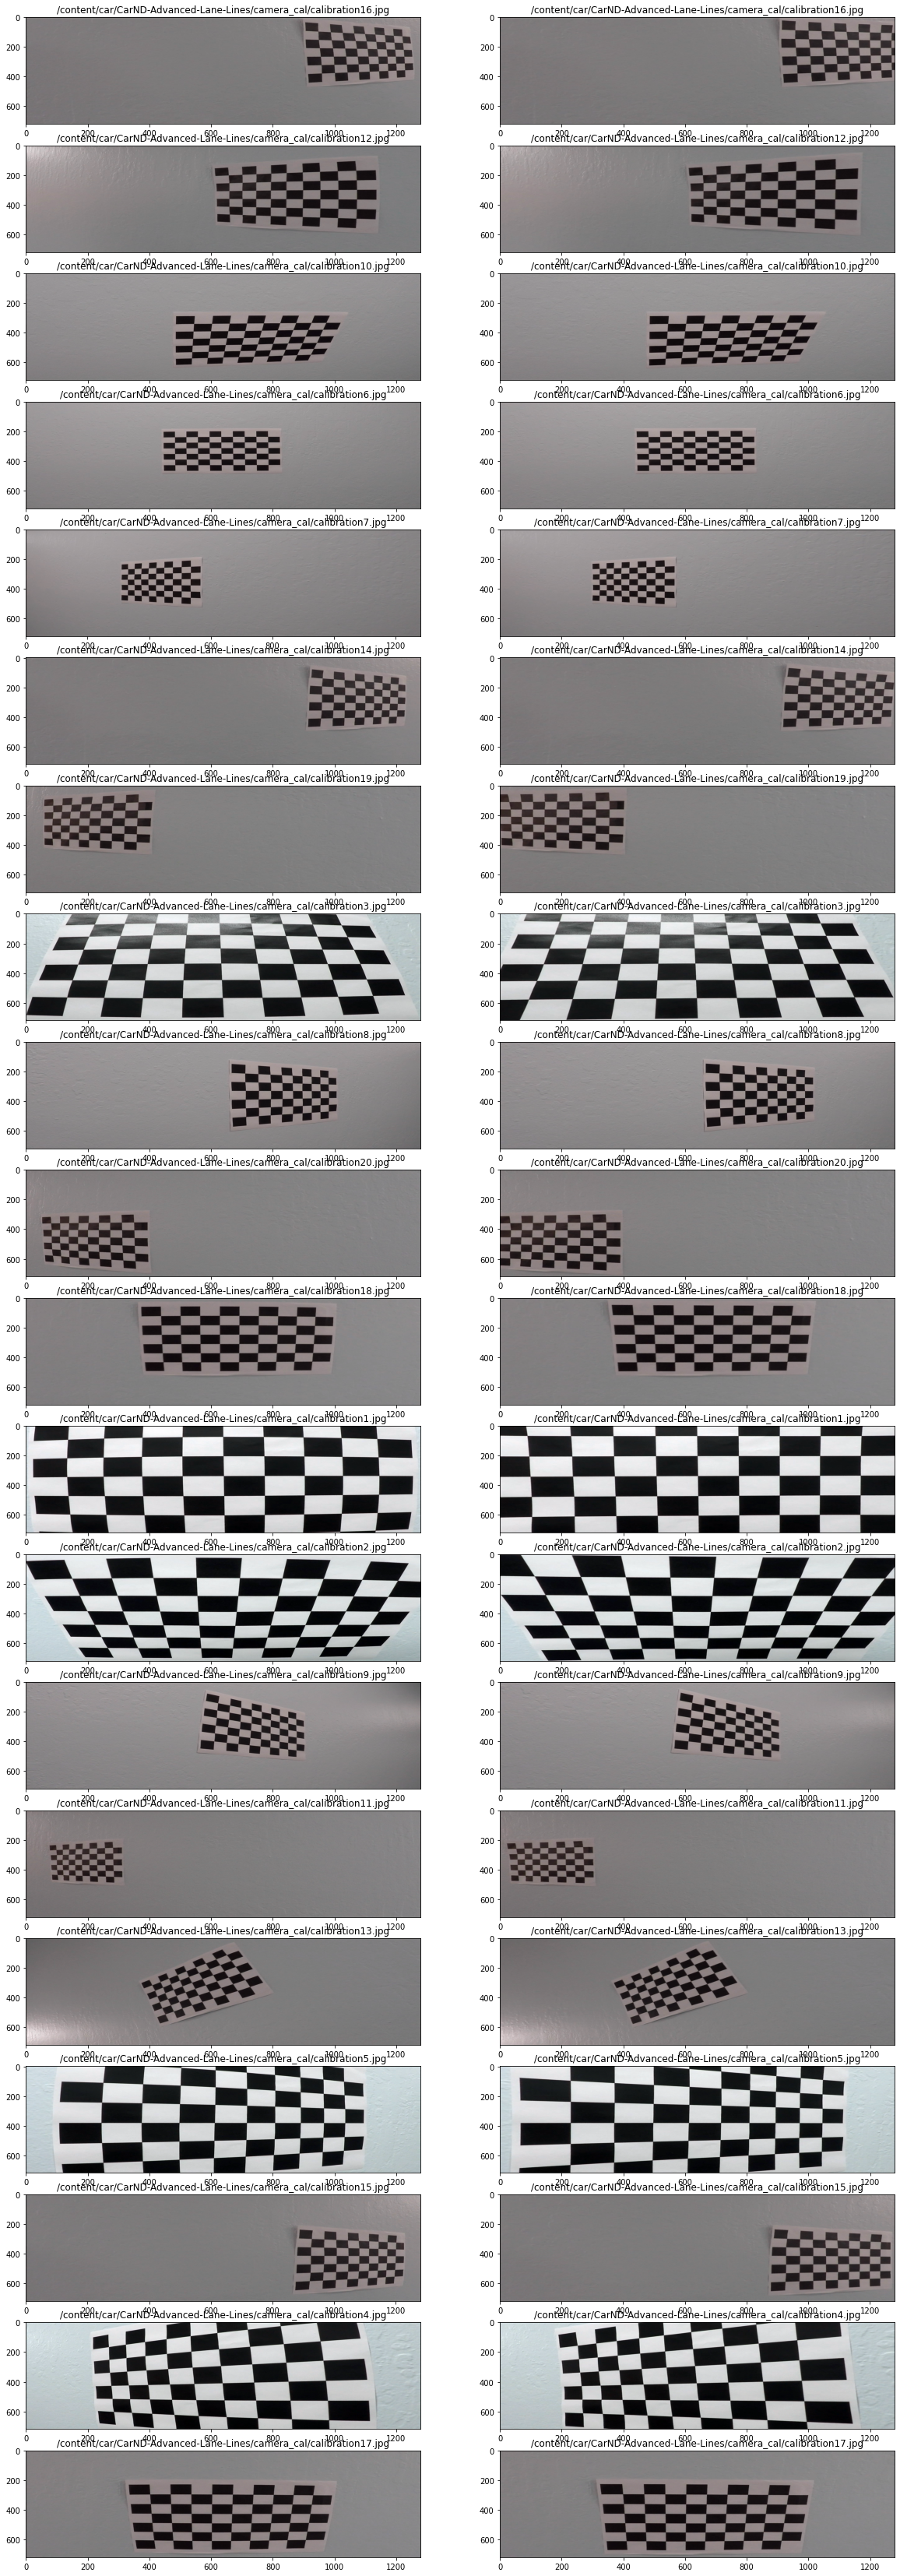

In [9]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from math import ceil
#%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob(os.path.join(data_folder, 'camera_cal/calibration*.jpg'))

rows = len(images)
plt.figure(figsize=(20,60))
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
if ret:
    for i, fname in enumerate(images):
        img = cv2.imread(fname)
        plt.subplot(rows, 2, i*2+1,  title=fname), plt.imshow(img, aspect='auto')
        dst = cv2.undistort(img, mtx, dist, None, mtx)
        plt.subplot(rows, 2, i*2+2,  title=fname), plt.imshow(dst, aspect='auto')

# Advanced Line Finder

In [0]:
#Finder V.2
import cv2
import numpy as np
import pickle


class AdvLaneFinder2:
    def __init__(   self, filter_size=7, threshold1=200, threshold2=230, 
                    rho = 4, theta = np.pi/180, min_votes = 25, min_line_length = 40, max_line_gap = 40, 
                    s_thresh_lower=124, s_thresh_upper=205, sx_thresh_lower=26, sx_thresh_upper=62,
                    cv_color=cv2.COLOR_RGB2GRAY, color=[255, 0, 0], thickness=4, mean_rate = 0.9, 
                    pos_intersect_ratio=10, neg_intersect_ratio=10, draw_all=False, dist_mtx_file='undist.p', M_transform_file='m_trans.p'):

        self._undist = False
        self._filter_size = filter_size
        self._threshold1 = threshold1
        self._threshold2 = threshold2

        self._rho = rho # distance resolution in pixels of the Hough grid
        self._theta = theta # angular resolution in radians of the Hough grid
        self._min_votes = min_votes     # minimum number of votes (intersections in Hough grid cell)
        self._min_line_length = min_line_length #minimum number of pixels making up a line
        self._max_line_gap = max_line_gap    # maximum gap in pixels between connectable line segments
        
        self._s_thresh_lower = s_thresh_lower
        self._s_thresh_upper = s_thresh_upper
        self._sx_thresh_lower = sx_thresh_lower
        self._sx_thresh_upper = sx_thresh_upper
        self._r_color = 0

        self._cv_color = cv_color #cv2.COLOR_BGR2GRAY or cv2.COLOR_RGB2GRAY
        self._color = color # color for detected and approximated lanes
        self._thickness = thickness # hough lines thickness
        self._mean_rate = mean_rate  # means*mean_rate + current_values*(1 - mean_rate)
        self._draw_all = draw_all   # switch all hough lines besides approximated on and off
        self._pos_intersect_ratio = pos_intersect_ratio # pos_intersect_treshold = - img.heght * pos_intersect_ratio
        self._neg_intersect_ratio = neg_intersect_ratio # neg_intersect_treshold = img.heght + img.heght * pos_intersect_ratio
        self._FLOAT_TRESHOLD = 0.01
        self._mtx = None
        self._dist = None
        self._M = None
        self._dist_mtx_file = dist_mtx_file
        self._M_transform_file = M_transform_file
        
        self._means = np.zeros((2,2), dtype=float) # slope_pos, slope_neg, intersect_pos, intersect_neg

        self._offset = 200
        self._offset_y = 0 # hide motor hood on the picture 
        # polynomials
        self._left_fit = []
        self._right_fit = []
        self._left_fit_real = []
        self._right_fit_real = []
        
        self.read_dist_mtx(self._dist_mtx_file)
        self.read_M_transform(self._M_transform_file)

 

    def _grayscale(self, img):
        return cv2.cvtColor(img, self._cv_color)
        
    def get_radius(self, poly, x):
        
        res = np.power((1+np.square(2*poly[0]*x+poly[1])), 3/2)/np.abs(2*poly[0])
        return res
        
    def _img_overlay_color(self, back, fore, x, y, opaque=True):
        # for small image use cv.resize in main programm:
        # overlay = cv2.resize(self._edge_img, None, fx=0.2, fy=0.2, interpolation = cv2.INTER_AREA)

        if len(fore.shape)==2:
            overlay = cv2.cvtColor(fore, cv2.COLOR_GRAY2RGB)
        else:
            overlay = fore
        rows, cols, channels = overlay.shape  
        if opaque:
            overlay_copy = overlay
        else:
            trans_indices = overlay[...,2] != 0 # Where not transparent
            overlay_copy = back[y:y+rows, x:x+cols] 
            overlay_copy[trans_indices] = overlay[trans_indices]
            
        out_img = back.copy()
        out_img[y:y+rows, x:x+cols] = overlay_copy
        return out_img

    def read_dist_mtx(self, file_name):
        with open(file_name, 'rb') as config_dictionary_file:
            dist_pickle = pickle.load(config_dictionary_file)
        self._mtx = dist_pickle["mtx"]
        self._dist = dist_pickle["dist"]

    def read_M_transform(self, file_name):
        with open(file_name, 'rb') as m_file:
            self._M = pickle.load(m_file)
        #self._M = dict_pickle["M"]

    def transform(self, img):
        '''
        perspective transformation of img with self._M matrix
        '''
        img_size = (img.shape[1], img.shape[0])
        #self._transformed = cv2.warpPerspective(img, self._M, img_size)
        return cv2.warpPerspective(img, self._M, img_size)
        
    def undistort_img(self, img):
        return cv2.undistort(img, self._mtx, self._dist, None, self._mtx)

    def gaussian_blur(self, img):
        """Applies a Gaussian Noise kernel"""
        return cv2.GaussianBlur(img, (self._filter_size, self._filter_size), 0)

    def canny(self, img):
        """Applies the Canny transform"""
        return cv2.Canny(img, self._threshold1, self._threshold2)

    def region_of_interest(self, img):
        """
        Applies an image mask.
        
        Only keeps the region of the image defined by the polygon
        formed from `vertices`. The rest of the image is set to black.
        `vertices` should be a numpy array of integer points.
        """
        #defining a blank mask to start with
        imshape = img.shape
        vertices = np.array([[(0,imshape[0]),(0, imshape[0]/2+imshape[0]*0.1), 
                                (imshape[1], imshape[0]/2+imshape[0]*0.1),
                                (imshape[1],imshape[0])]], 
                                dtype=np.int32)
        mask = np.zeros_like(img)   
        
        #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
        if len(img.shape) > 2:
            channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255
            
        #filling pixels inside the polygon defined by "vertices" with the fill color    
        cv2.fillPoly(mask, vertices, ignore_mask_color)
        
        #returning the image only where mask pixels are nonzero
        masked_image = cv2.bitwise_and(img, mask)
        return masked_image

    def _draw_means(self, img, lines):
        """Computes slope and intersect means, approximates and drows lines"""
        means = np.zeros((2,2), dtype=float)
        counts = np.zeros(2, dtype=int)
        
        for line in lines:
            x1,y1,x2,y2,sl,intcpt = line
            means[int(sl < 0)] += sl,intcpt
            counts[int(sl < 0)] += 1
        
        for i in range(2):
            if counts[i]>0:
                means[i] /= counts[i]
        if abs(self._means.all()) < self._FLOAT_TRESHOLD:
            self._means = means
            #print('means init')
        for i in range(2):
            if counts[i]>0:
                self._means[i] = self._means[i]*self._mean_rate + means[i]*(1 - self._mean_rate)

            if np.isnan(self._means[i]).any():
                continue
            if abs(self._means[i,0])<self._FLOAT_TRESHOLD:
                continue
            y1 = self._means_y0 #img.shape[0]//2 + img.shape[0]//10
            y2 = img.shape[0]-1
            x1 = int((y1 - self._means[i,1])/self._means[i,0])
            x2 = int((y2 - self._means[i,1])/self._means[i,0])
            cv2.line(img, (x1, y1), (x2, y2), self._color, self._thickness)
        return img

    def _select_lines(self, img, lines, color=[255, 255, 0], thickness=4):
        """Removes Hough lines they are off criteria from the mean list
            can draw these lines for control"""
        _lines = []
        _short_line = []
        for line in lines:
            for x1,y1,x2,y2 in line:
                if abs(x2-x1) < 1:
                    continue
                slope = round((y2-y1)/(x2-x1),1)
                if np.isnan(slope) or np.isinf(slope):
                    continue
                intercept = int(round(y1 - slope*x1))
                if slope > 0 and ((x1+x2<img.shape[1]) or(intercept< -img.shape[0]//self._pos_intersect_ratio)): 
                    if self._draw_all:
                        cv2.line(img, (x1, y1), (x2, y2), [0, 255, 255], thickness)
                elif slope < 0 and ((x1+x2>img.shape[1]) or(intercept<(img.shape[0] + img.shape[0]//self._neg_intersect_ratio))):
                    if self._draw_all:
                        cv2.line(img, (x1, y1), (x2, y2), [0, 255, 255], thickness)
                elif abs(slope) < 0.5 or abs(slope) > 0.85:
                    if self._draw_all:
                        cv2.line(img, (x1, y1), (x2, y2), [0, 255, 255], thickness)
                else:
                    if self._draw_all:
                        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                    _short_line = [round(x1), round(y1), round(x2), round(y2), slope, intercept]
                    _lines.append(_short_line)
        return _lines            
                    

    def _hough_lines(self, img):
        """
        `img` should be the output of a Canny transform.
        Returns an image with hough lines drawn.
        """
        lines = cv2.HoughLinesP(img, self._rho, self._theta, self._min_votes, np.array([]), 
            minLineLength=self._min_line_length, maxLineGap=self._max_line_gap)
            
        #line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
        #self._draw_lines(line_img, lines)
        return lines

    def find_lane_pixels(self, binary_warped):
        y_base_position = binary_warped.shape[0] - self._offset_y
        # Take a histogram of the bottom half of the image
        #histogram = np.sum(binary_warped[binary_warped.shape[0]//2:y_base_position,:], axis=0)
        histogram = np.sum(binary_warped[y_base_position - binary_warped.shape[0]//5:y_base_position,:], axis=0)
       # Create an output image to draw on and visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # HYPERPARAMETERS
        # Choose the number of sliding windows
        nwindows = 9
        # Set the width of the windows +/- margin
        margin = 250
        # Set minimum number of pixels found to recenter window
        minpix = 50

        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(y_base_position//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = y_base_position - (window+1)*window_height
            win_y_high = y_base_position - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 
            
            # Identify the nonzero pixels in x and y within the window #
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        return leftx, lefty, rightx, righty, out_img

    def fit_poly(self, img_shape, leftx, lefty, rightx, righty):
        # Generate y values for plotting
        ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
        right_fitx = 1*ploty**2 + 1*ploty
        left_fitx = right_fitx
        if len(leftx):
            left_fit = np.polyfit(lefty, leftx, 2)
            left_fit_real = np.polyfit(lefty*self.ym_per_pix, leftx*self.xm_per_pix, 2)
            if len(self._left_fit)==0:
                self._left_fit = left_fit
                self._left_fit_real = left_fit_real
            else:
                for i in range(len(self._left_fit)):
                    self._left_fit[i] = self._left_fit[i]*self._mean_rate + left_fit[i]*(1 - self._mean_rate)
                    self._left_fit_real[i] = self._left_fit_real[i]*self._mean_rate + left_fit_real[i]*(1 - self._mean_rate)
            
            if len(self._left_fit):
                left_fitx = self._left_fit[0]*ploty**2 + self._left_fit[1]*ploty + self._left_fit[2]
        if len(rightx):
            right_fit = np.polyfit(righty, rightx, 2)
            right_fit_real = np.polyfit(righty*self.ym_per_pix, rightx*self.xm_per_pix, 2)
            if len(self._right_fit)==0:
                self._right_fit = right_fit
                self._right_fit_real = right_fit_real
            else:
                for i in range(len(self._right_fit)):
                    self._right_fit[i] = self._right_fit[i]*self._mean_rate + right_fit[i]*(1 - self._mean_rate)
                    self._right_fit_real[i] = self._right_fit_real[i]*self._mean_rate + right_fit_real[i]*(1 - self._mean_rate)

            if len(self._right_fit):
                right_fitx = self._right_fit[0]*ploty**2 + self._right_fit[1]*ploty + self._right_fit[2]

        left_fitx[left_fitx>=img_shape[1]] = img_shape[1] - 1
        right_fitx[right_fitx>=img_shape[1]] = img_shape[1] - 1

        left_fitx[left_fitx < 0] = 0
        right_fitx[right_fitx < 0] = 0

        return np.int16(left_fitx), np.int16(right_fitx), np.int16(ploty)

    def fit_polynomial(self, binary_warped):
        # Find our lane pixels first
        leftx, lefty, rightx, righty, out_img = self.find_lane_pixels(binary_warped)

        # Fit a second order polynomial to each using `np.polyfit`
        left_fitx, right_fitx, ploty = self.fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)

        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # Plots the left and right polynomials on the lane lines
        out_img[ploty, left_fitx] = [255, 255, 0]
        out_img[ploty, right_fitx] = [255, 255, 0]

        #plt.plot(left_fitx, ploty, color='yellow')
        #plt.plot(right_fitx, ploty, color='yellow')

        return out_img

    def pipeline(self, inp_img): # , s_thresh=(170, 255), sx_thresh=(20, 100)
        s_thresh = (self._s_thresh_lower, self._s_thresh_upper)
        sx_thresh = (self._sx_thresh_lower, self._sx_thresh_upper)
        img = np.copy(inp_img)
        # Convert to HLS color space and separate the V channel
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        l_channel = hls[:,:,1]
        s_channel = hls[:,:,2]
        # Sobel x
        sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
        # Threshold x gradient
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

        # Sobel R
        sobelr = cv2.Sobel(img[:,:,self._r_color], cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelr = np.absolute(sobelr) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobelr = np.uint8(255*abs_sobelr/np.max(abs_sobelr))
        # Threshold R gradient
        srbinary = np.zeros_like(scaled_sobelr)
        srbinary[(scaled_sobelr >= sx_thresh[0]) & (scaled_sobelr <= sx_thresh[1])] = 1
        
        # Threshold color channel
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
        # Stack each channel
        #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
        color_binary = np.dstack((srbinary, sxbinary, s_binary)) * 255
        return color_binary

    def search_around_poly(self, binary_warped):
        # HYPERPARAMETER
        # Choose the width of the margin around the previous polynomial to search
        # The quiz grader expects 100 here, but feel free to tune on your own!
        margin = 100

        # Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        ### Set the area of search based on activated x-values ###
        ### within the +/- margin of our polynomial function ###
        left_lane_inds = ((nonzerox>(self._left_fit[0]*(nonzeroy**2)+self._left_fit[1]*nonzeroy+
                            self._left_fit[2]-margin))&
                            (nonzerox<(self._left_fit[0]*(nonzeroy**2)+self._left_fit[1]*nonzeroy+
                            self._left_fit[2]+margin)))
        right_lane_inds = ((nonzerox>(self._right_fit[0]*nonzeroy**2+self._right_fit[1]*nonzeroy+
                            self._right_fit[2]-margin))&
                            (nonzerox<(self._right_fit[0]*nonzeroy**2+self._right_fit[1]*nonzeroy+
                            self._right_fit[2]+margin)))

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        # Fit new polynomials
        left_fitx, right_fitx, ploty = self.fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
        
        ## Visualization ##
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        
        # Plots the left and right polynomials on the lane lines
        result[ploty, left_fitx] = [255, 255, 0]
        result[ploty, right_fitx] = [255, 255, 0]

        return result

    def draw_lanes(self, img):
        """Pipeline for finding lanes"""
        tmp_img = self.grayscale(image)

        tmp_img = self.gaussian_blur(img)
        tmp_img = self.canny(tmp_img)
        tmp_img = self.region_of_interest(tmp_img)
        _lines = self._hough_lines(tmp_img)
        
        if _lines is None: return None
        
        lane_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
        _lines = self._select_lines(lane_img, _lines)
        tmp_img = self._draw_means(lane_img, _lines)

        return cv2.addWeighted(tmp_img, 0.8, img, 1., 0.) #[:,:,0]

    def measure_curvature(self, pict_shape):
        '''
        Calculates the curvature of polynomial functions in meters.
        '''
        # Define y-value where we want radius of curvature
        # We'll choose the maximum y-value, corresponding to the bottom of the image

        y_eval = pict_shape[0] * self.ym_per_pix
        left_curverad = self.get_radius(self._left_fit_real, y_eval)
        right_curverad = self.get_radius(self._right_fit_real, y_eval)
        return left_curverad, right_curverad

    def trans_back(self, warped, orig_img):
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        if len(warp_zero.shape)==3:
            color_warp = warp_zero 
        else:
            color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        
        ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
        left_fitx = self._left_fit[0]*ploty**2 + self._left_fit[1]*ploty + self._left_fit[2]
        right_fitx = self._right_fit[0]*ploty**2 + self._right_fit[1]*ploty + self._right_fit[2]
        left_fitx[left_fitx>=warped.shape[1]] = warped.shape[1] - 1
        right_fitx[right_fitx>=warped.shape[1]] = warped.shape[1] - 1
        left_fitx[left_fitx < 0] = 0
        right_fitx[right_fitx < 0] = 0

       # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (flag WARP_INVERSE_MAP)
        newwarp = cv2.warpPerspective(color_warp, self._M, (warped.shape[1], warped.shape[0]),
             flags=cv2.WARP_INVERSE_MAP) 
        # Combine the result with the original image
        return cv2.addWeighted(orig_img, 1, newwarp, 0.3, 0)
        
    def get_position(self, img):
    
        ploty = img.shape[0]
        left_line = self._left_fit[0]*ploty**2 + self._left_fit[1]*ploty + self._left_fit[2]
        right_line = self._right_fit[0]*ploty**2 + self._right_fit[1]*ploty + self._right_fit[2]
        current_pos = (ploty - right_line + left_line)//2 * self.xm_per_pix
        return current_pos

    def draw_lanes(self, image):
        self._orig_image = self.undistort_img(image)
        self._orig_image[-100:,:,:] = 0 # hide motor hood on the picture
        self._means_y0 = self._orig_image.shape[0]//2 + self._orig_image.shape[0]//8
        self.ym_per_pix = 110/self._orig_image.shape[0] # meters per pixel in y dimension
        self.xm_per_pix = 3.7/(self._orig_image.shape[1]-200) # meters per pixel in x dimension - offset

        self._transformed = self.transform(self._orig_image)
        pipeline_img = self.pipeline(self._transformed)
        if len(self._left_fit)==0 and len(self._right_fit)==0:
            polynomial_img = self.fit_polynomial(self._grayscale(pipeline_img))

        overlay = cv2.resize(self._transformed, None, fx=0.2, fy=0.2, interpolation = cv2.INTER_AREA)
        self._orig_image = self._img_overlay_color(self._orig_image, overlay, 5, 5)        

        if len(self._left_fit)>0 or len(self._right_fit)>0:
            around = self.search_around_poly(self._grayscale(pipeline_img))
            overlay = cv2.resize(around, None, fx=0.2, fy=0.2, interpolation = cv2.INTER_AREA)
            self._orig_image = self._img_overlay_color(self._orig_image, overlay, (6+self._orig_image.shape[1]//5), 5)        

        curv_left, curv_right = np.int32(self.measure_curvature(pipeline_img.shape))
        self._orig_image = self.trans_back(self._transformed, self._orig_image)
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        fontScale = 1
        position = self.get_position(self._orig_image)
        if position<0:
            str_pos = f"Vehicle is {np.abs(position):.2f}m left of center"
        else:
            str_pos = f"Vehicle is {position:.2f}m right of center"
        cv2.putText(self._orig_image, f'Radius of Curvature {np.int_(curv_left+curv_right)//2}(m)', 
                    (10,30), font, fontScale, (255,255,255), 2, cv2.LINE_AA)
        cv2.putText(self._orig_image, str_pos, 
                    (10,65), font, fontScale, (255,255,255), 2, cv2.LINE_AA)
        return self._orig_image
        

## Test on Videos

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)720896/45929032 bytes (1.6%)1949696/45929032 bytes (4.2%)3768320/45929032 bytes (8.2%)6234112/45929032 bytes (13.6%)9854976/45929032 bytes (21.5%)13541376/45929032 bytes (29.5%)17268736/45929032 bytes (37.6%)21028864/45929032 bytes (45.8%)24838144/45929032 bytes (54.1%)28680192/45929032 bytes (62.4%)32169984/45929032 bytes (70.0%)34660352/45929032 bytes (75.5%)38133760/

In [0]:
def process_clip(f_callback, file_name, base_path, inp_dir='test_videos', output_dir='test_videos_output'):
    clip_output = os.path.join(base_path, output_dir, file_name)
    ##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
    clip1 = VideoFileClip(os.path.join(base_path, inp_dir, file_name)) 
    white_clip = clip1.fl_image(f_callback) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(clip_output, audio=False)

In [22]:
file_name = 'project_video.mp4' # 'challenge_video.mp4' #'project_video.mp4' harder_challenge_video challenge.mp4 solidYellowLeft.mp4
clip_out_dir = "test_videos_output"
!mkdir {clip_out_dir}
finder = AdvLaneFinder2(color=[0, 0, 255], filter_size=7, threshold1=200, threshold2=215, pos_intersect_ratio=20, 
                            s_thresh_lower=57, sx_thresh_lower=26, sx_thresh_upper=62,
                            mean_rate=0.9, draw_all=False)
process_clip(finder.draw_lanes, file_name, data_folder, inp_dir='')

mkdir: cannot create directory ‘test_videos_output’: File exists
[MoviePy] >>>> Building video /content/car/CarND-Advanced-Lane-Lines/test_videos_output/project_video.mp4
[MoviePy] Writing video /content/car/CarND-Advanced-Lane-Lines/test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [03:46<00:00,  5.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/car/CarND-Advanced-Lane-Lines/test_videos_output/project_video.mp4 

CPU times: user 3min 56s, sys: 6.14 s, total: 4min 3s
Wall time: 3min 48s
